# GitHub repositories analysis

In [223]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

## Read the data

In [224]:
files = glob.glob("./data/**/*.csv", recursive=True)
print("Encontrados", len(files), "ficheros")

Encontrados 36 ficheros


In [225]:
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [226]:
df["date"] = pd.to_datetime(df["ts"], format='%Y-%m-%d')

In [229]:
ts_max = df["ts"].unique().max()
today = df[df.ts==ts_max]
head_total = 5 if today.ts.count()>5 else today.ts.count()

In [230]:
columns=["name","views_total","views_uniques","clones_total"]
today[columns].sort_values(by=["views_total","views_uniques"], ascending=False).head(head_total)

,name,views_total,views_uniques,clones_total
230,ml-github,4,1,6
231,ms-helm-chart,3,1,0
228,influxdb-telegraf-grafana,2,2,0
227,golang-rest-api-cassandra,1,1,0
225,DO180-apps,0,0,2


In [231]:
repos = df.name.unique().tolist()

In [233]:
dict_df_repos = dict()
for repo_name in repos:
    dict_df_repos[repo_name] = df[df.name==repo_name]

## Data analysis

In [234]:
df_grouped = df.groupby(['name']).agg({"date": ["min"], "stars_count": ["max"],"clones_uniques": ["sum"],"views_total": ["sum", "max"]})

### Views

In [235]:
views_best_quantile = 0.75
views_worst_quantile = 0.25
best_views_percentile = df_grouped[('views_total', 'sum')].quantile(views_best_quantile)
worst_views_percentile = df_grouped[('views_total', 'sum')].quantile(views_worst_quantile)
print("Best views over:", best_views_percentile)
print("Worst views under:", worst_views_percentile)

Best views over: 18.0
Worst views under: 0.0


In [236]:
views=df_grouped[('views_total')]
views_best = views[views['sum'] > best_views_percentile]
views_best.sort_values(by='sum', ascending=False)

,sum,max
name,,
kotlin-ktor,217,41
quarkus-kotlin-example,178,46
ocp-monitoring-golang,169,133
ml-github,126,41
golang-rest-api-cassandra,80,27
istio-wasm-filter-golang,73,24
golang-k8s-helm-helloworld,62,42
mqtt-golang-influxdb,50,25
kustomize-vs-helm,42,24


#### Best views repositories

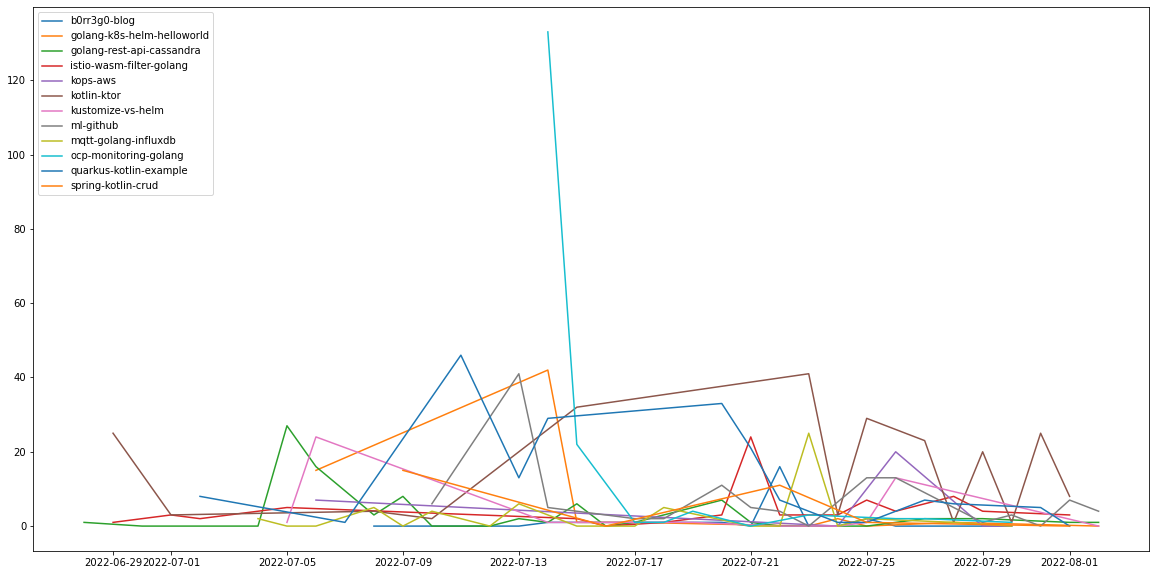

In [239]:
plt.figure(figsize=(20,10))
for repo_name in views_best.index.tolist():
    df_r = dict_df_repos[repo_name].sort_values(by="date")
    x = df_r.date
    y = df_r.views_total
    plt.plot(x, y, label=repo_name)
    
plt.legend(loc = "upper left")

#### Sum views total

In [243]:
df_total_views=df.groupby(['date']).agg({"views_total": ["sum"]}).sort_values(by="date", ascending=True)

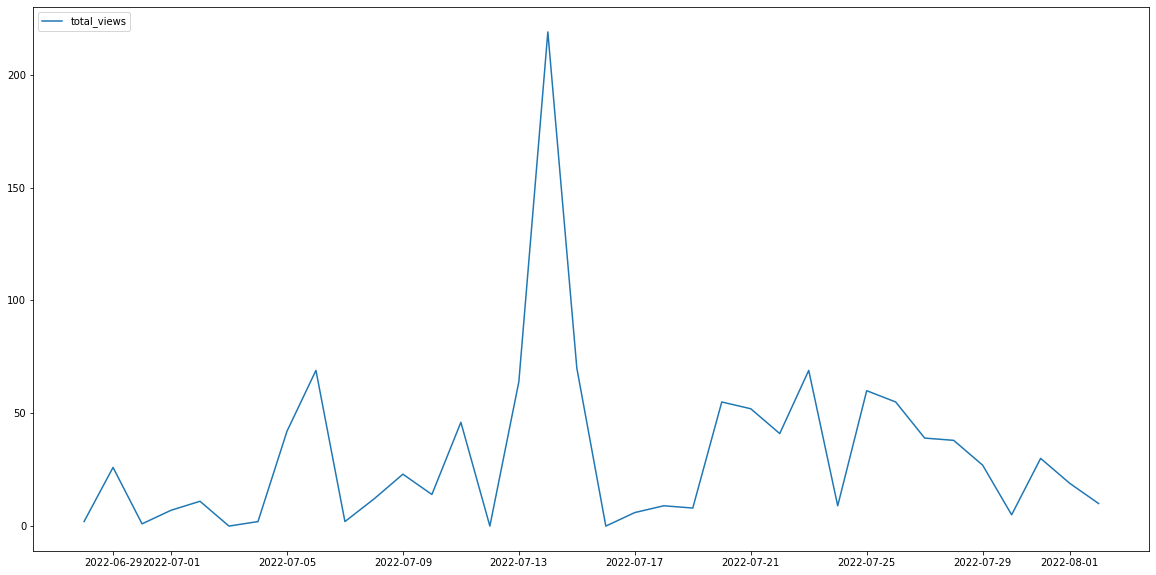

In [244]:
plt.figure(figsize=(20,10))
x = df_total_views.index
y = df_total_views[('views_total', 'sum')]
plt.plot(x, y, label="total_views")
plt.legend(loc = "upper left")

### Clones

In [245]:
# calculate the best 25% repositories
best_clones_quantile = 0.75
worst_clones_quantile = 0.25
best_clones_percentile = df_grouped[('clones_uniques', 'sum')].quantile(best_clones_quantile)
worst_clones_percentile = df_grouped[('clones_uniques', 'sum')].quantile(worst_clones_quantile)
print("Best clones over:", best_clones_percentile)
print("Worst clones under:", worst_clones_percentile)

Best clones over: 3.75
Worst clones under: 1.0


In [246]:
clones=df_grouped[('clones_uniques')]
clones_best = clones[clones['sum'] > best_clones_percentile]
clones_best.sort_values(by='sum', ascending=False)

,sum
name,
golang-rest-api-cassandra,473
ta,301
iot-devices-crud,215
mqtt-golang-influxdb,171
ml-github,60
b0rr3g0-blog,16
DO180-apps,12
ocp-monitoring-golang,10
istio-wasm-filter-golang,4


# Stars

In [247]:
# calculate the best 50% repositories
best_stars_quantile = 0.75
worst_stars_quantile = 0.25
best_stars_percentile = df_grouped[('stars_count', 'max')].quantile(best_stars_quantile)
worst_stars_percentile = df_grouped[('stars_count', 'max')].quantile(worst_stars_quantile)
print("Best stars over:", best_stars_percentile)
print("Worst stars under:", worst_stars_percentile)

Best stars over: 1.0
Worst stars under: 0.0


In [248]:
stars=df_grouped[('stars_count')]
stars_best = stars[stars['max'] > best_stars_percentile]
stars_best.sort_values(by=['max'], ascending=False)

,max
name,
mqtt-golang-influxdb,10
spring-kotlin-crud,6
kotlin-ktor,5
kops-aws,4
kustomize-vs-helm,3
ta,3
golang-k8s-helm-helloworld,2
golang-rest-api-cassandra,2
quarkus-kotlin-example,2


# Red zone

In [249]:
repos = pd.read_csv("./repos.csv")

# remove colum
repos = repos.iloc[:,1:]
# remove owner
repos = repos.drop(labels="owner",axis=1)
# add num topics
#repos["num_topics"] = len(repos.topics.str.split(','))
def count_topics(topics):
    return 0 if topics.count(',') == 0 else topics.count(',')+1
repos["topics_count"] = repos.apply(lambda row : count_topics(row.topics), axis=1)
# remove topics
repos = repos.drop(labels="topics",axis=1)
# format date
repos["latest_commit_date"] = pd.to_datetime(repos["latest_commit_date"], format='%Y%m%d')
# days until latest commit
today = pd.to_datetime('today')
repos["days_latest_commit"] = (today - repos.latest_commit_date).dt.days

In [286]:
df_grouped.loc['golang-azure-eventhub'][('date', 'min')]

Timestamp('2022-07-16 00:00:00')

In [251]:
def extract_views_by_day(row):
    return 
repos["views_by_day"] = repos.apply(lambda row: extract_views_by_day(row.name),axis=1)

SyntaxError: invalid syntax (2428450813.py, line 1)

In [250]:
repos.sort_values(by="days_latest_commit")

,name,latest_commit_date,topics_count,days_latest_commit
42,ml-github,2022-08-02,0,0
3,b0rr3g0-blog,2022-07-26,0,7
35,kops-aws,2022-07-26,0,7
48,ocp-monitoring-golang,2022-07-14,0,19
15,golang-k8s-helm-helloworld,2022-07-14,5,19
...,...,...,...,...
61,spring-cloud-ms2,2017-04-17,0,1933
45,ms-config-server,2017-03-15,0,1966
56,spring-boot-elk,2017-03-15,0,1966
62,spring-data-mongodb,2016-09-22,0,2140


In [180]:
df_red_zone = df_grouped[df_grouped[('stars_count', 'max')] <= worst_stars_percentile]
df_red_zone = df_red_zone[df_red_zone[('clones_uniques', 'sum')] <= worst_clones_percentile]
df_red_zone = df_red_zone[df_red_zone[('views_total', 'sum')] <= worst_views_percentile]
df_red_zone.index.values.tolist()

['REST-Services-MySQL',
 'amq-streams-workshop',
 'asciidoc-base',
 'dbgjerez',
 'golang-azure-eventhub',
 'golang-azure-eventhub-kafka',
 'iot-esp8266-dht11',
 'iot-esp8266-relay-web-server',
 'kubernetes-golang-operator',
 'kubernetes-helm-operator',
 'ml-learning',
 'ocp-HTPasswd-file-provider',
 'service-mesh-wasm-go',
 'spring-cloud-config',
 'spring-cloud-dataflow',
 'spring-cloud-eureka',
 'workshop-uca-aws-deploy']